<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Google_Notebook_and_Tensorflow_(III).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a Dataset from Files

To use a manually downloaded dataset with TensorFlow Datasets (TFDS), the dataset structure and metadata must be properly set up to be recognized by TFDS. Unfortunately, TFDS expects a certain structure for its datasets, which can be challenging when using manually downloaded files.

## Download the Dataset:
---
**Download the cell_images.zip file from the provided URL.**

---

In [1]:
import tensorflow as tf
import pathlib
import zipfile
import os

dataset_url = 'https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip'

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='cell_images.zip', extract=False)
data_dir = pathlib.Path(data_dir)

353452851/353452851 [==============================] - 4s 0us/step


## Extract the Dataset

We need to convert a path to a `pathlib.Path` object, ensure a specific directory exists, extract the contents of a zip file into that directory, and then verify the extraction by printing a message.

El módulo `pathlib` en Python proporciona una forma de manejar rutas de archivos y directorios de manera más intuitiva y orientada a objetos en comparación con el módulo `os` tradicional. Un `pathlib.Path` es una clase del módulo `pathlib` que representa una ruta de archivo o directorio en el sistema de archivos.

---
**Unzip the downloaded file.**

---

In [2]:
# Convert to a pathlib Path object
data_dir = pathlib.Path(data_dir)

# Define the malaria dataset directory path
malaria_dir = pathlib.Path('/content/datasets/malaria')
# Ensure the malaria directory exists
malaria_dir.mkdir(parents=True, exist_ok=True)

# Extract the zip file into the manual directory
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(malaria_dir)

# Verify the extraction
print(f'Extracted files to {malaria_dir}')

Extracted files to /content/datasets/malaria


## Inspect the Dataset

The dataset contains several thousand photos of cell images in two subdirectories (classes) with one cell image per class. The directory structure is as follows thanks to this snipet:

---
**Display the datapath structure.**

---

In [3]:
import os

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + os.path.basename(root_dir))

    if os.path.isdir(root_dir):
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                print_directory_tree(item_path, level + 1)

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Print the directory tree
print_directory_tree(data_dir)


cell_images
    |-- Uninfected
    |-- Parasitized


Or with pathlib.

In [4]:
from pathlib import Path

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + root_dir.name)

    if root_dir.is_dir():
        for item in root_dir.iterdir():
            if item.is_dir():
                print_directory_tree(item, level + 1)

# Define the data directory
data_dir = Path('/content/datasets/malaria/cell_images')

# Print the directory tree
print_directory_tree(data_dir)


cell_images
    |-- Uninfected
    |-- Parasitized


---
**Visualiza una imagen de cada directorio**

---

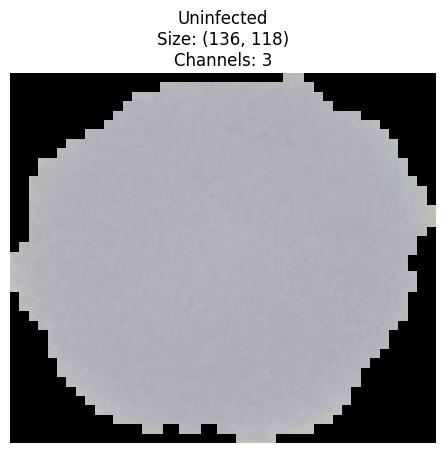

Uninfected Image: C180P141NThinF_IMG_20151201_165423_cell_93.png
Size: (136, 118)
Channels: 3


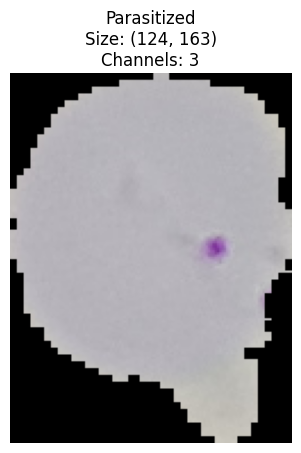

Parasitized Image: C180P141NThinF_IMG_20151201_165423_cell_173.png
Size: (124, 163)
Channels: 3


In [5]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Define the data directory
data_dir = Path('/content/datasets/malaria/cell_images')

# Get an image from each category
uninfected_image_path = next(data_dir.glob('Uninfected/*.png'))
parasitized_image_path = next(data_dir.glob('Parasitized/*.png'))

# Open and display the Uninfected image
uninfected_image = Image.open(uninfected_image_path)
plt.imshow(uninfected_image)
plt.axis('off')
plt.title(f'Uninfected\nSize: {uninfected_image.size}\nChannels: {len(uninfected_image.getbands())}')
plt.show()

# Print Uninfected image details
print(f'Uninfected Image: {uninfected_image_path.name}')
print(f'Size: {uninfected_image.size}')
print(f'Channels: {len(uninfected_image.getbands())}')

# Open and display the Parasitized image
parasitized_image = Image.open(parasitized_image_path)
plt.imshow(parasitized_image)
plt.axis('off')
plt.title(f'Parasitized\nSize: {parasitized_image.size}\nChannels: {len(parasitized_image.getbands())}')
plt.show()

# Print Parasitized image details
print(f'Parasitized Image: {parasitized_image_path.name}')
print(f'Size: {parasitized_image.size}')
print(f'Channels: {len(parasitized_image.getbands())}')


An important detail is that each image has a different size.

## Display some images

From the "Parasitized" and "Uninfected" directories, you can use the matplotlib library to display 4 images from each directory:

---
**Display some images from both classes**

---

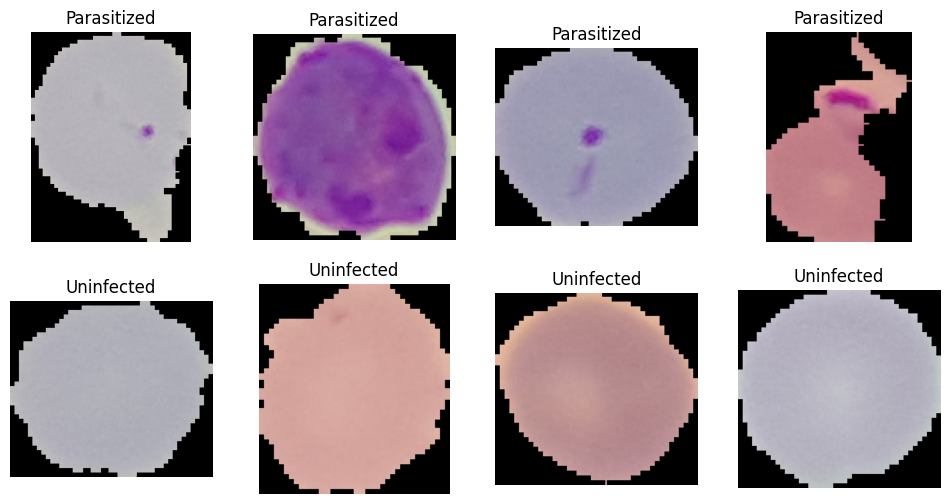

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Define the number of images to display from each class
num_images_per_class = 4

# Define the paths to the image directories
parasitized_dir = os.path.join(data_dir, 'Parasitized')
uninfected_dir = os.path.join(data_dir, 'Uninfected')

# Get the list of images in each directory
parasitized_images = os.listdir(parasitized_dir)[:num_images_per_class]
uninfected_images = os.listdir(uninfected_dir)[:num_images_per_class]

# Display Parasitized images
plt.figure(figsize=(12, 6))
for i, image_name in enumerate(parasitized_images):
    img_path = os.path.join(parasitized_dir, image_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Parasitized')

# Display Uninfected images
for i, image_name in enumerate(uninfected_images):
    img_path = os.path.join(uninfected_dir, image_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+5)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uninfected')

plt.show()


Efectively, notice that images are not of the same size!

## Count the number of images

Count the number of images in the "Parasitized" and "Uninfected" directories

---
**Count number of images in both classes**

---

In [7]:
import os

# Define the data directory
data_dir = '/content/datasets/malaria/cell_images'

# Count the number of images in each subdirectory
parasitized_count = len(os.listdir(os.path.join(data_dir, 'Parasitized')))
uninfected_count = len(os.listdir(os.path.join(data_dir, 'Uninfected')))

# Print the counts
print(f'Parasitized: {parasitized_count} images')
print(f'Uninfected: {uninfected_count} images')


Parasitized: 13780 images
Uninfected: 13780 images


# Load the Dataset

Using Keras `image_dataset_from_directory` you can create train and validation sets from a directory. The `tf.keras.preprocessing.image_dataset_from_directory` utility offers incredible convenience for loading and parsing images off disk!


The `tf.keras.preprocessing.image_dataset_from_directory` function in TensorFlow expects a specific directory structure to correctly load an image dataset from a directory. This structure follows a convention where images are organized into subdirectories based on their labels or classes.

### Directory Structure

The directory structure should be as follows:

```
dataset_directory/
    class_a/
        img1.jpg
        img2.jpg
        ...
    class_b/
        img1.jpg
        img2.jpg
        ...
    ...
```

### Using `image_dataset_from_directory`

Here's an example of how to use the `image_dataset_from_directory` function to load this dataset:

```python
import tensorflow as tf

# Path to the main dataset directory
dataset_directory = "path/to/dataset"

# Create the image dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,       # Split the dataset into training and validation
    subset="training",          # Specify that this is the training subset
    seed=123,                   # Seed for randomization
    image_size=(256, 256),      # Size to resize images to
    batch_size=32               # Batch size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    validation_split=0.2,       # Split the dataset into training and validation
    subset="validation",        # Specify that this is the validation subset
    seed=123,                   # Seed for randomization
    image_size=(256, 256),      # Size to resize images to
    batch_size=32               # Batch size
)
```

### Important Parameters of `image_dataset_from_directory`

- `directory`: Path to the main dataset directory.
- `validation_split`: Fraction of the dataset to reserve for validation.
- `subset`: Specifies whether the subset is training (`"training"`) or validation (`"validation"`).
- `seed`: Seed for randomization to ensure consistent training and validation splits.
- `image_size`: A tuple specifying the size to resize all images to.
- `batch_size`: Size of the batches of data.

### Additional Notes

- Images should be in a format supported by TensorFlow (such as JPEG or PNG).
- The names of the subdirectories will be used as class labels.
- The function can also handle automatic splitting of training and validation datasets if the `validation_split` parameter is specified.

By following this structure and using the `image_dataset_from_directory` function correctly, you can load and prepare your image dataset for use in deep learning models with TensorFlow.


We set batch size initially to 32 because it tends to be a good size for many of the datasets with which we work. We set image height and width at 64 because we get good results and the model trains really fast. **At the end of this notebook, feel free to experiment with these parameters.**

**NOTE:** *Our inspection revealed that image size differs. Since TensorFlow models expect images of the same size, we must resize them.*

## Create Training and Test/Val Sets
The `tf.keras.preprocessing.image_dataset_from_directory` utility generates a `tf.data` Dataset from image files in a directory. The utility is very useful because it allows us to conveniently split, seed, resize, and batch data. Let’s split data into 80% training and 20% test sets. Theoretically we must set this split based on numerous experiments. Of course, you can tweak
the sizes with your own experiment. The combination of the `validation_split` and `subset` parameters determines the train and test splits.

---
**Create Training and Test Sets**

---

In [8]:
import tensorflow as tf
import pathlib

# Define the data directory
data_dir = pathlib.Path('/content/datasets/malaria/cell_images')

# Load the dataset using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Split 80% for training and 20% for validation
    subset="training",
    seed=123,
    image_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64),
    batch_size=32
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


---
**Obtain information about the datasets (train_ds)**

---

In [9]:
class_names = train_ds.class_names
print(f'Class names: {class_names}')

num_batches = len(train_ds)
print(f'Number of batches: {num_batches}')

for images, labels in train_ds.take(1):
    print(f'Batch shape: {images.shape}')
    print(f'Labels shape: {labels.shape}')

    image_shape = images.shape[1:]
    print(f'Image size: {image_shape[:2]}')
    print(f'Number of channels: {image_shape[2]}')

    print(f'Example label[0]: {labels[0].numpy()}')

    # Convert to numpy array for easier inspection
    images_array = images.numpy()

    # Print the range of pixel values for the first image in the batch
    print(f'Min pixel value: {images_array[0].min()}')
    print(f'Max pixel value: {images_array[0].max()}')



Class names: ['Parasitized', 'Uninfected']
Number of batches: 689
Batch shape: (32, 64, 64, 3)
Labels shape: (32,)
Image size: (64, 64)
Number of channels: 3
Example label[0]: 0
Min pixel value: 0.0
Max pixel value: 234.41796875


It is not normalized yet.!!

## Display images and labels from some batch

---
**Show a batch of images and labels**

---

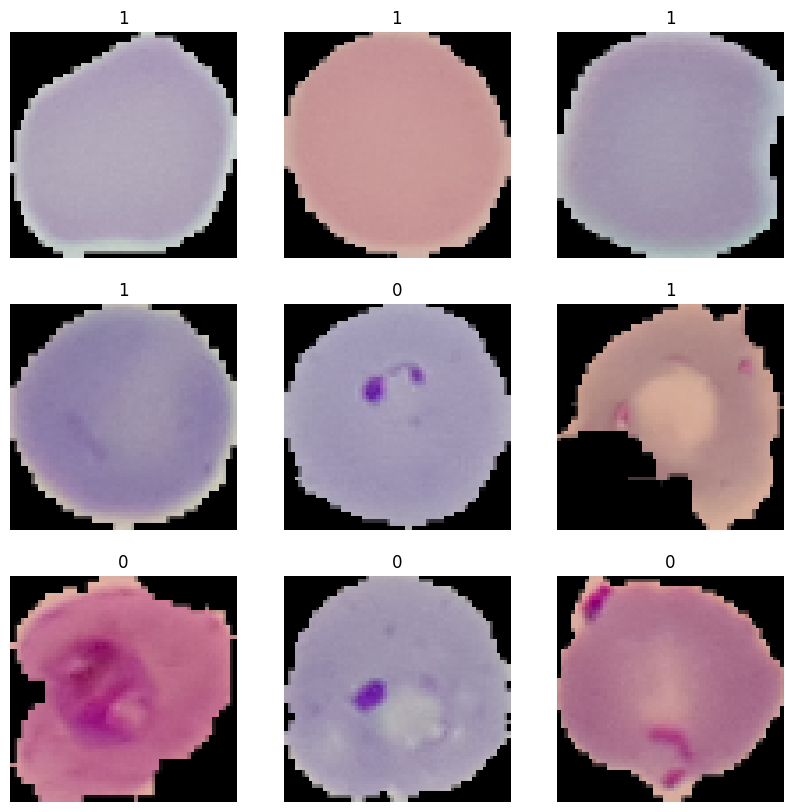

In [10]:
# Show a batch of images and labels
import matplotlib.pyplot as plt

# train_ds is divided into batches. If I use take(1),
# it is like taking a whole batch. 32 images but we taken only 9
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

plt.show()

# Parse Data

---
***Inspect* Tensors**

---

In [11]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Take the first batch from the training set and preserve shapes:

---
**Inspect the first batch**

---

In [12]:
for img, lbl in train_ds.take(1):
  print (img.shape, lbl.shape)
cell_shape, just_img = img.shape[1:],\
                         img.shape[1:3]


(32, 64, 64, 3) (32,)


We take the first batch to help us inspect a batch from the dataset. We preserve the shape of the batch and batch size for use in the model. Batch size is 32, and images are resized to 224 × 224 × 3. The 3 value indicates that images have three channels, which means they are RGB (color). Labels have shape (32,) that corresponds to the 32 batch size of labels.


## Get Class Names
We already identified the classes from the directory names. But we can now access them with the `class_names` method:

In [13]:
# Check the class names
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


# Display images from a batch in memory

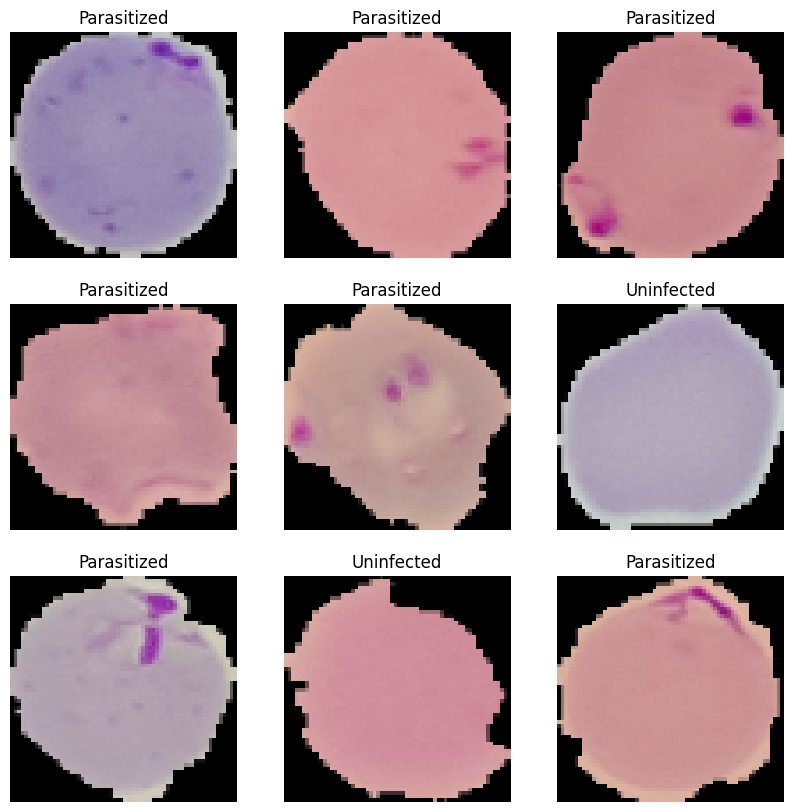

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

## Scale (normalize) the Data
As noted earlier in the chapter, a pixel is represented by 256 values. So RGB channel values are in the [0, 255] range. Since neural networks work better with small values, data is typically scaled to be in the [0, 1] range.

---
**Create a function to normalize images:**

---

In [15]:
def format_image(image, label):
  image = tf.image.resize(image, just_img) / 255.0
  return image, label

The function is used when we configure the input pipeline.
## Configure the Dataset for Performance
Use buffered prefetching to get data from disk to mitigate I/O issues. Cache data to keep images in memory after they’re loaded off disk. Caching saves operations like file opening and data reading from being executed during each epoch.
## Build the Input Pipeline
Shuffle the training set, and cache and prefetch train and test sets:

### 1. `shuffle(shuffle_size)`
- **Purpose**: The `shuffle` operation is used to randomly shuffle the order of elements in the dataset.
- **Why**: Shuffling the training data is important to prevent the model from learning the order of the data, which can lead to overfitting and poor generalization. By randomizing the data, the model is more likely to learn meaningful patterns rather than memorizing the sequence of the training data.
- **How it works**: `shuffle_size` specifies the buffer size from which the dataset will draw samples. For example, if `shuffle_size` is 100, the dataset maintains a buffer of 100 elements and randomly selects elements from this buffer.

### 2. `cache()`
- **Purpose**: The `cache` operation is used to store the results of expensive operations (like loading data from disk and preprocessing) in memory after they are computed the first time.
- **Why**: Caching improves performance by avoiding the need to repeatedly perform the same expensive operations each time an epoch runs. This can significantly speed up the training process.
- **How it works**: Once the data is cached, subsequent epochs can use the cached data directly, bypassing the need for repeated loading and preprocessing.

### 3. `prefetch(buffer_size)`
- **Purpose**: The `prefetch` operation allows the dataset to fetch batches of data in the background while the model is training.
- **Why**: Prefetching helps to overlap the data loading and model training processes, which can improve training speed and efficiency. By prefetching, the model doesn't need to wait for data to be loaded before it can continue training.
- **How it works**: The `buffer_size` determines how many batches to prepare in advance. A typical value is `buffer_size=1`, meaning it will fetch the next batch while the current batch is being processed by the model.



In [16]:
shuffle_size = 100

train_cds = train_ds.map(format_image).\
  shuffle(shuffle_size).cache().prefetch(1)
test_cds = test_ds.map(format_image).\
  cache().prefetch(1)


---
**Inspect the normalization**

---



In [18]:
import numpy as np

# Collect images into lists
train_images_list = []
test_images_list = []

# Append images to the lists
for x, _ in train_cds:
    train_images_list.append(x.numpy())

for x, _ in test_cds:
    test_images_list.append(x.numpy())

# Convert lists to NumPy arrays
train_images = np.concatenate(train_images_list, axis=0)
test_images = np.concatenate(test_images_list, axis=0)

# Find and print min and max values
print("Training dataset - min value:", train_images.min(), "max value:", train_images.max())
print("Test dataset - min value:", test_images.min(), "max value:", test_images.max())


Training dataset - min value: 0.0 max value: 1.0
Test dataset - min value: 0.0 max value: 1.0


we will collect all the images into lists using append, then convert these lists into NumPy arrays.

Iterate over the datasets (`train_cds` and `test_cds`). Convert each image tensor to a NumPy array using `x.numpy()` and append it to the respective list.



---
**Note** since training and test data have already been batched by the utility, do not batch when building the input pipeline!

---

## Build the Model
Since we are working with large color images, we need to build a convolutional neural network (CNN) model to garner respectable performance because our images are color with higher pixel counts.


We need additional libraries for a CNN:

### What is a CNN?

A Convolutional Neural Network (CNN) is a type of deep learning algorithm specifically designed to process structured grid data, such as images. CNNs are particularly effective for tasks involving visual data, making them the go-to architecture for image recognition, classification, and computer vision applications.

### Key Components of a CNN
1. **Input Layer**:
    - **Function** This layer is designed to receive the raw data in its original or prepocesed form.
    - **Output** An image, usually represented as a 3D array (height, width, and color channels).

2. **Convolutional Layers**:
    - **Function**: These layers apply a set of filters (kernels) to the input data. Each filter slides (convolves) over the input image, computing dot products between the filter and the overlapping regions of the image.
    - **Output**: The result is a set of feature maps, which highlight various features of the input such as edges, textures, or patterns.
    
3. **Activation Functions**:
    - **Function**: After convolution, an activation function like ReLU (Rectified Linear Unit) is applied to introduce non-linearity into the model. This helps the network to learn complex patterns.
    
4. **Pooling Layers**:
    - **Function**: Pooling layers reduce the spatial dimensions (width and height) of the feature maps, which helps in reducing the computational load and controls overfitting.
    - **Types**: Common types of pooling include max pooling (which takes the maximum value in each region) and average pooling (which takes the average value).
    
5. **Fully Connected Layers**:
    - **Function**: These layers are typically placed at the end of the network and are used to make final predictions. They are fully connected in the sense that each neuron in one layer is connected to every neuron in the next layer.
    
6. **Softmax Layer**:
    - **Function**: In classification tasks, a softmax activation function is applied in the final layer to convert the network’s outputs into probability distributions over the class labels.

### How CNNs Work

1. **Input Image**:
    - The input to a CNN is typically an image represented as a multi-dimensional array (height, width, and channels).

2. **Convolution and Pooling**:
    - The image passes through a series of convolutional and pooling layers, which progressively extract higher-level features from the raw pixel values.

3. **Flattening**:
    - After several layers of convolutions and pooling, the output is flattened into a one-dimensional vector to be fed into the fully connected layers.

4. **Classification**:
    - The fully connected layers process the flattened vector and output the final classification probabilities.

### Benefits of CNNs

- **Parameter Sharing**: Convolutional layers share weights across the spatial dimensions, which reduces the number of parameters and computational complexity.
- **Translation Invariance**: By learning local patterns (features), CNNs can recognize objects regardless of their position in the image.
- **Hierarchical Feature Learning**: CNNs automatically learn a hierarchy of features, from low-level features like edges to high-level features like object parts.

### Applications of CNNs

- **Image Classification**: Identifying the category to which an image belongs.
- **Object Detection**: Detecting and localizing objects within an image.
- **Image Segmentation**: Dividing an image into multiple segments or regions, often used in medical imaging.


Convolutional Neural Networks are a powerful class of neural networks that excel in handling image data. Their ability to learn hierarchical features and reduce the number of parameters through convolution and pooling operations makes them well-suited for various computer vision tasks. By leveraging these capabilities, CNNs have achieved state-of-the-art performance in many real-world applications.

---

**Import libraries**

---

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

---
**Get the number of classes for use in the model**

---

In [22]:
num_classes = len(class_names)
num_classes

2

---
**Clear any previous models and generate a random seed:**

---

In [23]:
import numpy as np

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

---
**Create a multilayer CNN**

---

In [24]:
cell_model = tf.keras.Sequential([
  Conv2D(32, 3, activation='relu',
         input_shape=cell_shape),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])

The first layer scales the data. The second layer contains 32 neurons with a 3 × 3 convolutional kernel (or filter). Activation is relu. The third layer uses maximum pooling to reduce the spatial size of a layer by just keeping the maximum values. As such,
the pooling layer reduces image dimensionality without losing important features or patterns. The next four layers repeat the same pattern as the second and third layers. The Flatten layer converts pooled data into a single column because a Dense layer expects data in this form. The final Dense layer enables classification and prediction.

---
Compile and Train the Model
Compile with `SparseCategoricalCrossentropy()`:

---

In [26]:
cell_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


1. **`cell_model.compile()`**:
   - This method configures the model for training. It specifies the optimizer, the loss function, and the metrics to monitor during training and evaluation.

2. **`optimizer='adam'`**:
   - **Optimizer**: The optimizer is a key component in training a neural network. It updates the model's weights based on the computed gradients.
   - **Adam Optimizer**: Adam (short for Adaptive Moment Estimation) is a popular optimizer that combines the benefits of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It is efficient, has low memory requirements, and works well for a wide range of problems.
   - **Why Adam**: Adam is often used because it adjusts the learning rate for each parameter dynamically, leading to faster convergence and better performance.

3. **`loss=tf.losses.SparseCategoricalCrossentropy()`**:
   - **Loss Function**: The loss function is used to measure how well the model's predictions match the true labels. During training, the model tries to minimize this loss.
   - **Sparse Categorical Crossentropy**: This is a specific type of loss function used for classification tasks where the target labels are integers.
     - **Categorical Crossentropy**: This loss function is used when you have multiple classes. It measures the difference between the predicted probability distribution and the true distribution (one-hot encoded). One-hot encoding transforms a categorical variable (with integer or string labels) into a binary vector. Each position in the vector corresponds to one possible category, and only the position corresponding to the category of the data point is set to 1, while all other positions are set to 0.
     - **Sparse**: The "sparse" version is used when your labels are integers instead of one-hot encoded vectors. For example, if you have three classes, your labels might be `[0, 1, 2]` instead of `[[1,0,0], [0,1,0], [0,0,1]]`.
   - **Why Sparse Categorical Crossentropy**: It is computationally efficient when dealing with a large number of classes because it avoids the need to convert integer labels to one-hot encoded labels. It is especially useful when you have a large dataset with many classes.

4. **`metrics=['accuracy']`**:
   - **Metrics**: Metrics are used to evaluate the performance of the model. They do not affect the training process but provide insights into how well the model is doing.
   - **Accuracy**: Accuracy is a common metric for classification tasks. It measures the percentage of correct predictions out of the total predictions made.
   - **Why Accuracy**: It is a simple and intuitive measure of performance, making it easy to understand how well the model is performing on the training and validation datasets.

This setup is commonly used in classification problems, particularly when dealing with image data in CNNs, to ensure that the model is trained effectively and evaluated properly.

In [27]:
# Print the model summary
cell_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

Since softmax is applied to outputs, we **don’t** set from_logits=True. Train the model:

In [28]:
history = cell_model.fit(
    train_cds,
    validation_data=test_cds,
    epochs=30)


Epoch 1/30
689/689 [==============================] - 8s 6ms/step - loss: 0.4335 - accuracy: 0.7747 - val_loss: 0.2252 - val_accuracy: 0.9227
Epoch 2/30
689/689 [==============================] - 4s 6ms/step - loss: 0.1681 - accuracy: 0.9472 - val_loss: 0.1432 - val_accuracy: 0.9514
Epoch 3/30
689/689 [==============================] - 4s 6ms/step - loss: 0.1396 - accuracy: 0.9554 - val_loss: 0.1317 - val_accuracy: 0.9568
Epoch 4/30
689/689 [==============================] - 4s 5ms/step - loss: 0.1230 - accuracy: 0.9597 - val_loss: 0.1304 - val_accuracy: 0.9574
Epoch 5/30
689/689 [==============================] - 4s 6ms/step - loss: 0.1127 - accuracy: 0.9617 - val_loss: 0.1255 - val_accuracy: 0.9561
Epoch 6/30
689/689 [==============================] - 4s 5ms/step - loss: 0.1013 - accuracy: 0.9648 - val_loss: 0.1269 - val_accuracy: 0.9561
Epoch 7/30
689/689 [==============================] - 4s 5ms/step - loss: 0.0901 - accuracy: 0.9681 - val_loss: 0.1316 - val_accuracy: 0.9563
Epoch 

---

**plot the metrics**

---

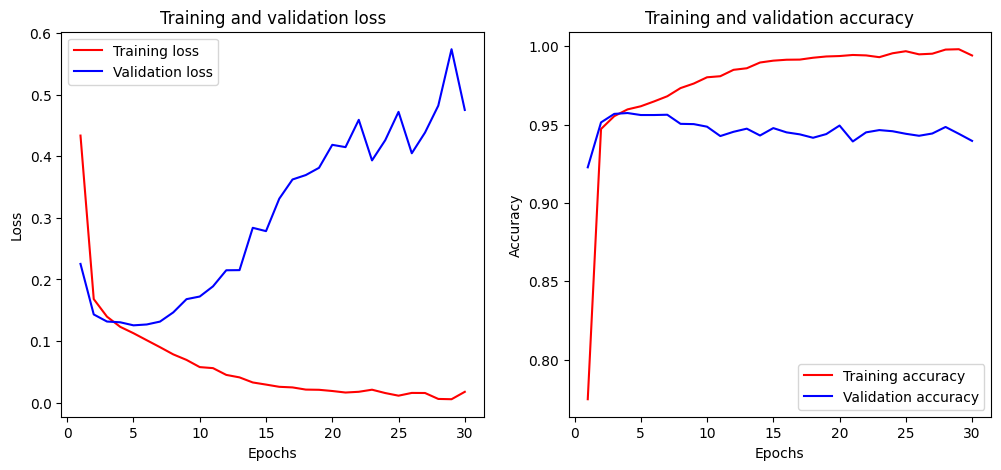

In [30]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from the history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot the loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Importance of Evaluating Metrics on a Separate Test Set

When training a machine learning model, it's crucial to assess its performance not just on the training data but on a separate test set. The primary metrics of interest, such as accuracy and loss, should be evaluated on this test set for several important reasons:

1. **Avoiding Overfitting**:
   - **Training Performance**: During training, the model learns patterns from the training data. If evaluated solely on this data, the metrics might be misleadingly high, especially if the model overfits by memorizing the training data rather than generalizing from it.
   - **Overfitting**: Overfitting occurs when a model learns the training data too well, including its noise and outliers, leading to poor performance on new, unseen data.

2. **Generalization Ability**:
   - **Test Set**: The test set consists of data the model has never seen during training. Evaluating performance on the test set gives a better indication of how well the model generalizes to new, unseen data.
   - **Real-World Performance**: This is crucial for understanding how the model will perform in real-world scenarios where it encounters data outside the training set.

3. **Reliable Performance Metrics**:
   - **Accuracy and Loss**: These metrics are more reliable and meaningful when calculated on the test set. They provide a true estimate of the model’s predictive power and help in comparing different models or tuning hyperparameters.
   - **Preventing Bias**: Evaluating on the training set can lead to biased results, as the model has already been exposed to this data and adjusted its parameters to fit it as closely as possible.

4. **Model Validation**:
   - **Validation Process**: During the model development process, it’s common to split the data into training, validation, and test sets. The validation set is used for tuning the model and preventing overfitting, while the test set is reserved for the final evaluation.
   - **Final Check**: Metrics from the test set act as a final check before deploying the model. They help ensure that the model is robust and ready for practical use.

In summary, evaluating metrics like accuracy and loss on a separate test set that was never used during training is essential for:
- Avoiding overfitting and ensuring the model generalizes well to new data.
- Providing a true and unbiased measure of the model's performance.
- Validating the model before deployment to ensure it will perform well in real-world scenarios.

This practice helps in building robust, reliable, and effective machine learning models that can successfully handle unseen data.

Test Loss: 0.47505319118499756
Test Accuracy: 0.9395753741264343


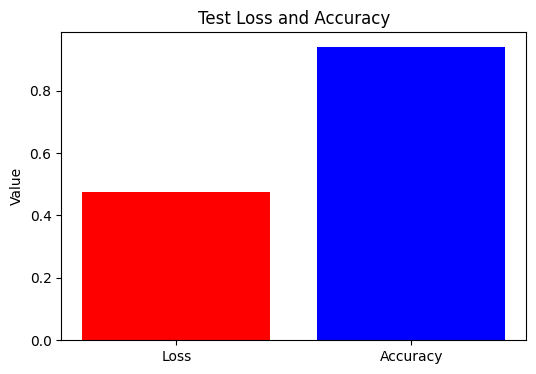

In [31]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = cell_model.evaluate(test_cds, verbose=0)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the test data
plt.figure(figsize=(6, 4))
plt.bar(['Loss', 'Accuracy'], [test_loss, test_accuracy], color=['red', 'blue'])
plt.title('Test Loss and Accuracy')
plt.ylabel('Value')
plt.show()

---

Obtain Confusion Matrix

---

173/173 [==============================] - 0s 2ms/step
Length of y_true: 5511
Length of y_pred_classes: 5511


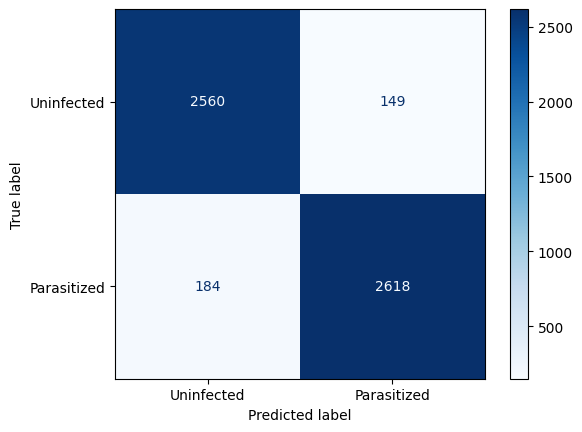

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions (predict labels) on the test set
y_pred = cell_model.predict(test_cds)
y_pred_classes = np.argmax(y_pred, axis=1)


# Get true labels
y_true = np.concatenate([y.numpy() for x, y in test_cds], axis=0)

print("Length of y_true:", len(y_true))
print("Length of y_pred_classes:", len(y_pred_classes))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Exercise: Improving Model Performance**

In this exercise, you will improve the performance of the proposed model in the notebook. You are allowed to increase the number of layers, use a different loss function, and change the optimizer to another different to Adam. You can also increase the number of epochs to 50.

Investigate and you can use ChatGPT

**Instructions**:
1. Load the dataset and preprocess it as necessary.
2. Build a neural network model, making modifications as mentioned above.
3. Compile the model with a suitable loss function and the optimizer (Adam?).
4. Train the model with 50 epochs.
5. Evaluate the model on the test set and print the test loss and accuracy.
6. Plot the test loss and accuracy.
7. Compute and visualize the confusion matrix to analyze the model's performance.
8. Create a ROC curve and analize the result obtained.

**Dataset**: you can use this dataset (malaria)or colorectal_histology (bonus and optative).

**Hints**:
- Experiment with different architectures, such as adding more layers or changing the number of neurons in each layer.
- Consider using dropout layers to prevent overfitting.
- Choose a suitable loss function depending on the task (e.g., categorical cross-entropy for classification).
- Experiment with different optimizers for efficient optimization.
- Monitor the training progress using validation data to avoid overfitting.
- Visualize the model's performance using appropriate plots and metrics.

Feel free to modify and adapt the exercise as needed to suit your learning objectives and preferences. Happy coding!

------------------------------------------------------------------ HASTA AQUI --------------

# Get Flowers from Google Cloud Storage
We demonstrated input pipelining with data from memory and from files. We can also pipeline data from cloud storage. Flowers data is hosted in a public bucket on Google Cloud Storage (GCS). So we can grab flower files from GCS. We can read flowers as JPEG files or as TFRecord files. For data modeling, we use TFRecord files. For optimal performance, we read from multiple TFRecord files at once. The TFRecord format is a simple format for storing a sequence of binary records. A TFRecord file contains a sequence of records, which can only be read sequentially.

## Read Flowers as JPEG Files and Perform Simple Processing
Read JPEG files based on a GCS pattern:


In [36]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
filenames = tf.io.gfile.glob(GCS_PATTERN)

GCS_PATTERN is a glob pattern that supports the “*” and “?” wildcards. **Globs** (also known as glob patterns) are patterns that can expand a wildcard pattern into a list of pathnames that match the given pattern.
Get the number of JPEG images:

In [37]:
num_images = len(filenames)
print ('Pattern matches {} images.'.format(num_images))

Pattern matches 3670 images.


Create a dataset of filenames from GCS_PATTERN and peruse its contents:

In [38]:
filenames_ds = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_ds.take(5):
  print (filename.numpy().decode('utf-8'))


gs://flowers-public/daisy/4141147800_813f660b47.jpg
gs://flowers-public/roses/7187035716_5d0fb95c31_n.jpg
gs://flowers-public/daisy/2607132536_d95198e619_n.jpg
gs://flowers-public/roses/15011625580_7974c44bce.jpg
gs://flowers-public/daisy/14564545365_1f1d267bf1_n.jpg


We need the data in (image, label) tuples to work with the images and labels independently. So create a function to return a dataset of (image, label) tuples

In [39]:
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(
      tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

Map the function to each filename to create a dataset of (image, label) tuples:

In [40]:
ds = filenames_ds.map(decode_jpeg_and_label)

Peruse:

In [41]:
for image, label in ds.take(5):
  print (image.numpy().shape,
         label.numpy().decode('utf-8'))

(333, 500, 3) dandelion
(240, 240, 3) tulips
(240, 320, 3) dandelion
(240, 201, 3) sunflowers
(240, 240, 3) dandelion


Display an image:

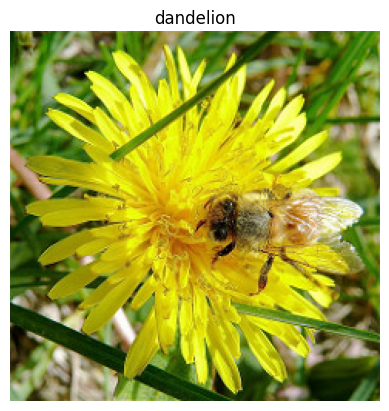

In [42]:
for img, lbl  in ds.take(1):
  plt.axis('off')
  plt.title(lbl.numpy().decode('utf-8'))
  fig = plt.imshow(img)


Although we don’t train with this dataset, let’s see how to convert text labels to encoded labels

In [43]:
for img, lbl in ds.take(1):
  label = lbl.numpy().decode('utf-8')
matches = tf.stack([tf.equal(label, s)\
                    for s in class_names], axis=-1)
one_hot = tf.cast(matches, tf.float32)
print (matches.numpy(), one_hot.numpy())
new_label = tf.math.argmax(one_hot)
new_label.numpy()

[False False] [0. 0.]


0

Take a label. Compare it against the class name list to find its position in the list. Create a one-hot vector. Convert the one-hot vector into a label tensor. We don’t train with this dataset because it is not the way to model complex data from GCS. But it is a simple way to load and inspect the data.
# Read and Process Flowers as TFRecord Files
The best way to model complex data from GCS is as TFRecord files. A TFRecord file stores data as a sequence of binary strings. Binary strings are very efficient to process.
## Read TFRecord Files
Read TFRecord files based on a GCS pattern:


In [ ]:
piece1 = 'gs://flowers-public/'
piece2 = 'tfrecords-jpeg-192x192-2/*.tfrec'
TFR_GCS_PATTERN = piece1 + piece2
tfr_filenames = tf.io.gfile.glob(TFR_GCS_PATTERN)

Get the number of buckets:

In [ ]:
num_images = len(tfr_filenames)
print ('Pattern matches {} image buckets.'.format(num_images))

We grabbed 16 buckets. Since there are 3670 flower files, 15 buckets contain 230 images (15 × 230 = 3,450), and the final bucket contains 220 images. Add 3,450 to 220 to get 3,670.

Display a file:

In [ ]:
filenames_tfrds = tf.data.Dataset.list_files(TFR_GCS_PATTERN)
for filename in filenames_tfrds.take(1):
  print (filename.numpy())

Set Parameters for Training
Set parameters for image resizing, pipelining, and number of epochs:


In [ ]:
IMAGE_SIZE = [192, 192]
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_SIZE = 100
EPOCHS = 5

Use AUTOTUNE to prompt the tf.data runtime, which tunes the value dynamically at runtime.

---
**Note** autotune is experimental, which means that the operation may change in the future.

---
Set validation split and class labels:


In [ ]:
VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Create data splits, validation steps, and steps per epoch as shown in Listing 1-8.

In [ ]:
split = int(len(tfr_filenames) * VALIDATION_SPLIT)
training_filenames = tfr_filenames[split:]
validation_filenames = tfr_filenames[:split]
print ('Splitting dataset into {} training files and {}'
        ' validation files'.format(
            len(tfr_filenames), len(training_filenames),
            len(validation_filenames)), end = ' ')
print ('with a batch size of {}.'.format(BATCH_SIZE))
validation_steps = int(3670 // len(tfr_filenames) *\
                       len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(tfr_filenames) *\
                      len(training_filenames)) // BATCH_SIZE
print ('There are {} batches per training epoch and {} '\
       'batches per validation run.'\
       .format(BATCH_SIZE, steps_per_epoch, validation_steps))

# Create Functions to Load and Process TFRecord Files
Create a function to parse a TFRecord file

In [ ]:
def read_tfrecord(example):
  features = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'class': tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.reshape(image, [*IMAGE_SIZE, 3])
  class_label = example['class']
  return image, class_label

The function accepts a TFRecord file. A dictionary holds datatypes common to TFRecords. The tf.string datatype converts the image to byte strings (list of bytes). The
tf.int64 converts the class label to a 64-bit integer scalar value. The TFRecord file is parsed into (image, label) tuples. The image element, a JPEG-encoded image, is decoded into a uint8 image tensor. The image tensor is scaled to the [0, 1] range for faster training. It is then reshaped to a standard size for model consumption. The class label element is cast to a scalar.

Create a function to load TFRecord files as `tf.data.Dataset`

In [ ]:
def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False
  dataset = tf.data.TFRecordDataset(
      filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

The function accepts TFRecord files. For optimal performance, code is included
to read from multiple TFRecord files at once. The options setting allows order-altering optimizations. As such, n files are read in parallel, and data order is disregarded in favor of reading speed.

Create a function to build an input pipeline from TFRecord files

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache()
  if train:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(SHUFFLE_SIZE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

The function accepts TFRecord files and calls the load_dataset function. The function continues by building an input pipeline by caching, repeating, shuffling, batching, and prefetching the dataset. Repeating and shuffling are only mapped to training data to follow best practices for a Keras dataset.

## Create Training and Test Sets
Instantiate the datasets:


In [ ]:
training_dataset = get_batched_dataset(
    training_filenames, train=True)
validation_dataset = get_batched_dataset(
    validation_filenames, train=False)
training_dataset, validation_dataset


Display an image and preserve the shape for the model:

In [ ]:
for img, lbl in training_dataset.take(1):
  plt.axis('off')
  plt.title(CLASSES[lbl[0].numpy()])
  fig = plt.imshow(img[0])
  tfr_flower_shape = img.shape[1:]


## Model Data
Clear and seed:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)


Create the model as shown

In [ ]:
tfr_model = Sequential([
  Conv2D(32, (3, 3), activation = 'relu',
         input_shape=tfr_flower_shape),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(2),
  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_classes, activation='sigmoid')
])

Inspect

In [ ]:
tfr_model.summary()

Compile:

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
tfr_model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])


Train:

In [ ]:
history = tfr_model.fit(training_dataset, epochs=EPOCHS,
                    verbose=1, steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    validation_data=validation_dataset)


## Summary
We built ML input pipeline examples from three types of data. The first experiments built pipelines from data loaded into memory. We then built a pipeline from external files. The final experiment built a pipeline from cloud storage.